# Pricing Basket Options

### Introduction
<br>
Suppose a <a href="https://www.investopedia.com/terms/b/basketoption.asp">basket option</a> with strike price $K$ and two underlying assets whose spot price at maturity $S_T^1$, $S_T^2$ follow given random distributions.
The corresponding payoff function is defined as:
<br>
<br>
$$\max\{S_T^1 + S_T^2 - K, 0\}$$
<br>
In the following, a quantum algorithm based on amplitude estimation is used to estimate the expected payoff, i.e., the fair price before discounting, for the option:
<br>
<br>
$$\mathbb{E}\left[ \max\{S_T^1 + S_T^2 - K, 0\} \right].$$
<br>
The approximation of the objective function and a general introduction to option pricing and risk analysis on quantum computers are given in the following papers:

- [Quantum Risk Analysis. Woerner, Egger. 2018.](https://arxiv.org/abs/1806.06893)
- [Option Pricing using Quantum Computers. Stamatopoulos et al. 2019.](https://arxiv.org/abs/1905.02666)

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

%matplotlib inline
import numpy as np

from qiskit import QuantumRegister, QuantumCircuit, execute, AncillaRegister, transpile
from qiskit_aer import Aer
from qiskit.utils import QuantumInstance
from qiskit.algorithms import IterativeAmplitudeEstimation, EstimationProblem
from qiskit.circuit.library import WeightedAdder, LinearAmplitudeFunction
from qiskit_finance.circuit.library import LogNormalDistribution

### Uncertainty Model

We construct a circuit to load a multivariate log-normal random distribution into a quantum state on $n$ qubits.
For every dimension $j = 1,\ldots,d$, the distribution is truncated to a given interval $[\text{low}_j, \text{high}_j]$ and discretized using $2^{n_j}$ grid points, where $n_j$ denotes the number of qubits used to represent dimension $j$, i.e., $n_1+\ldots+n_d = n$.
The unitary operator corresponding to the circuit implements the following: 

$$\big|0\rangle_{n} \mapsto \big|\psi\rangle_{n} = \sum_{i_1,\ldots,i_d} \sqrt{p_{i_1\ldots i_d}}\big|i_1\rangle_{n_1}\ldots\big|i_d\rangle_{n_d},$$

where $p_{i_1\ldots i_d}$ denote the probabilities corresponding to the truncated and discretized distribution and where $i_j$ is mapped to the right interval using the affine map:

$$ \{0, \ldots, 2^{n_j}-1\} \ni i_j \mapsto \frac{\text{high}_j - \text{low}_j}{2^{n_j} - 1} * i_j + \text{low}_j \in [\text{low}_j, \text{high}_j].$$

For simplicity, we assume both stock prices are independent and identically distributed.
This assumption just simplifies the parametrization below and can be easily relaxed to more complex and also correlated multivariate distributions.
The only important assumption for the current implementation is that the discretization grid of the different dimensions has the same step size.

In [2]:
# number of qubits per dimension to represent the uncertainty
num_uncertainty_qubits = 2

# parameters for considered random distribution
S = 2.0  # initial spot price
vol = 0.4  # volatility of 40%
r = 0.05  # annual interest rate of 4%
T = 40 / 365  # 40 days to maturity

# resulting parameters for log-normal distribution
mu = (r - 0.5 * vol**2) * T + np.log(S)
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2 / 2)
variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
stddev = np.sqrt(variance)

# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

# map to higher dimensional distribution
# for simplicity assuming dimensions are independent and identically distributed)
dimension = 2
num_qubits = [num_uncertainty_qubits] * dimension
low = low * np.ones(dimension)
high = high * np.ones(dimension)
mu = mu * np.ones(dimension)
cov = sigma**2 * np.eye(dimension)

# construct circuit
u = LogNormalDistribution(num_qubits=num_qubits, mu=mu, sigma=cov, bounds=list(zip(low, high)))

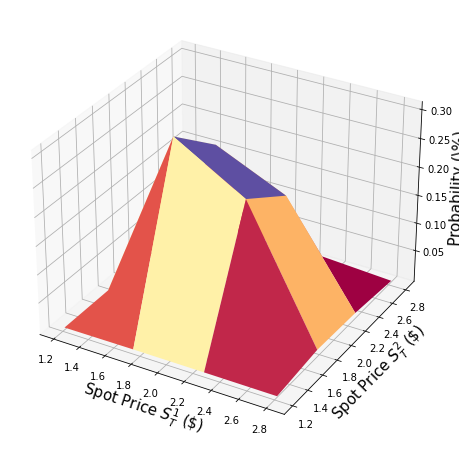

In [3]:
# plot PDF of uncertainty model
x = [v[0] for v in u.values]
y = [v[1] for v in u.values]
z = u.probabilities
# z = map(float, z)
# z = list(map(float, z))
resolution = np.array([2**n for n in num_qubits]) * 1j
grid_x, grid_y = np.mgrid[min(x) : max(x) : resolution[0], min(y) : max(y) : resolution[1]]
grid_z = griddata((x, y), z, (grid_x, grid_y))
plt.figure(figsize=(10, 8))
ax = plt.axes(projection="3d")
ax.plot_surface(grid_x, grid_y, grid_z, cmap=plt.cm.Spectral)
ax.set_xlabel("Spot Price $S_T^1$ (\$)", size=15)
ax.set_ylabel("Spot Price $S_T^2$ (\$)", size=15)
ax.set_zlabel("Probability (\%)", size=15)
plt.show()

### Payoff Function

The payoff function equals zero as long as the sum of the spot prices at maturity $(S_T^1 + S_T^2)$ is less than the strike price $K$ and then increases linearly.
The implementation first uses a weighted sum operator to compute the sum of the spot prices into an ancilla register, and then uses a comparator, that flips an ancilla qubit from $\big|0\rangle$ to $\big|1\rangle$ if $(S_T^1 + S_T^2) \geq K$.
This ancilla is used to control the linear part of the payoff function.

The linear part itself is approximated as follows.
We exploit the fact that $\sin^2(y + \pi/4) \approx y + 1/2$ for small $|y|$.
Thus, for a given approximation rescaling factor $c_\text{approx} \in [0, 1]$ and $x \in [0, 1]$ we consider
$$ \sin^2( \pi/2 * c_\text{approx} * ( x - 1/2 ) + \pi/4) \approx \pi/2 * c_\text{approx} * ( x - 1/2 ) + 1/2 $$ for small $c_\text{approx}$.

We can easily construct an operator that acts as 
$$\big|x\rangle \big|0\rangle \mapsto \big|x\rangle \left( \cos(a*x+b) \big|0\rangle + \sin(a*x+b) \big|1\rangle \right),$$
using controlled Y-rotations.

Eventually, we are interested in the probability of measuring $\big|1\rangle$ in the last qubit, which corresponds to
$\sin^2(a*x+b)$.
Together with the approximation above, this allows to approximate the values of interest.
The smaller we choose $c_\text{approx}$, the better the approximation.
However, since we are then estimating a property scaled by $c_\text{approx}$, the number of evaluation qubits $m$ needs to be adjusted accordingly.

For more details on the approximation, we refer to:
[Quantum Risk Analysis. Woerner, Egger. 2018.](https://arxiv.org/abs/1806.06893)

Since the weighted sum operator (in its current implementation) can only sum up integers, we need to map from the original ranges to the representable range to estimate the result, and reverse this mapping before interpreting the result. The mapping essentially corresponds to the affine mapping described in the context of the uncertainty model above.

In [4]:
# determine number of qubits required to represent total loss
weights = []
for n in num_qubits:
    for i in range(n):
        weights += [2**i]

# create aggregation circuit
agg = WeightedAdder(sum(num_qubits), weights)
n_s = agg.num_sum_qubits
n_aux = agg.num_qubits - n_s - agg.num_state_qubits  # number of additional qubits

In [5]:
# set the strike price (should be within the low and the high value of the uncertainty)
strike_price = 3.5

# map strike price from [low, high] to {0, ..., 2^n-1}
max_value = 2**n_s - 1
low_ = low[0]
high_ = high[0]
mapped_strike_price = (
    (strike_price - dimension * low_) / (high_ - low_) * (2**num_uncertainty_qubits - 1)
)

# set the approximation scaling for the payoff function
c_approx = 0.25

# setup piecewise linear objective fcuntion
breakpoints = [0, mapped_strike_price]
slopes = [0, 1]
offsets = [0, 0]
f_min = 0
f_max = 2 * (2**num_uncertainty_qubits - 1) - mapped_strike_price
basket_objective = LinearAmplitudeFunction(
    n_s,
    slopes,
    offsets,
    domain=(0, max_value),
    image=(f_min, f_max),
    rescaling_factor=c_approx,
    breakpoints=breakpoints,
)

In [6]:
# define overall multivariate problem
qr_state = QuantumRegister(u.num_qubits, "state")  # to load the probability distribution
qr_obj = QuantumRegister(1, "obj")  # to encode the function values
ar_sum = AncillaRegister(n_s, "sum")  # number of qubits used to encode the sum
ar = AncillaRegister(max(n_aux, basket_objective.num_ancillas), "work")  # additional qubits

objective_index = u.num_qubits

basket_option = QuantumCircuit(qr_state, qr_obj, ar_sum, ar)
basket_option.append(u, qr_state)
basket_option.append(agg, qr_state[:] + ar_sum[:] + ar[:n_aux])
basket_option.append(basket_objective, ar_sum[:] + qr_obj[:] + ar[: basket_objective.num_ancillas])

print(basket_option.draw())
print("objective qubit index", objective_index)

         ┌───────┐┌────────┐      
state_0: ┤0      ├┤0       ├──────
         │       ││        │      
state_1: ┤1      ├┤1       ├──────
         │  P(X) ││        │      
state_2: ┤2      ├┤2       ├──────
         │       ││        │      
state_3: ┤3      ├┤3       ├──────
         └───────┘│        │┌────┐
    obj: ─────────┤        ├┤3   ├
                  │        ││    │
  sum_0: ─────────┤4 adder ├┤0   ├
                  │        ││    │
  sum_1: ─────────┤5       ├┤1   ├
                  │        ││    │
  sum_2: ─────────┤6       ├┤2 F ├
                  │        ││    │
 work_0: ─────────┤7       ├┤4   ├
                  │        ││    │
 work_1: ─────────┤8       ├┤5   ├
                  │        ││    │
 work_2: ─────────┤9       ├┤6   ├
                  └────────┘└────┘
objective qubit index 4


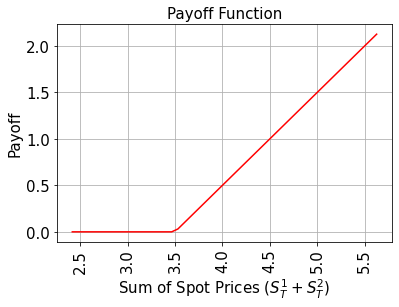

In [7]:
# plot exact payoff function (evaluated on the grid of the uncertainty model)
x = np.linspace(sum(low), sum(high))
y = np.maximum(0, x - strike_price)
plt.plot(x, y, "r-")
plt.grid()
plt.title("Payoff Function", size=15)
plt.xlabel("Sum of Spot Prices ($S_T^1 + S_T^2)$", size=15)
plt.ylabel("Payoff", size=15)
plt.xticks(size=15, rotation=90)
plt.yticks(size=15)
plt.show()

In [8]:
# evaluate exact expected value
sum_values = np.sum(u.values, axis=1)
exact_value = np.dot(
    u.probabilities[sum_values >= strike_price],
    sum_values[sum_values >= strike_price] - strike_price,
)
print("exact expected value:\t%.4f" % exact_value)

exact expected value:	0.4870


### Evaluate Expected Payoff

We first verify the quantum circuit by simulating it and analyzing the resulting probability to measure the $|1\rangle$ state in the objective qubit.

In [9]:
num_state_qubits = basket_option.num_qubits - basket_option.num_ancillas
print("state qubits: ", num_state_qubits)
transpiled = transpile(basket_option, basis_gates=["u", "cx"])
print("circuit width:", transpiled.width())
print("circuit depth:", transpiled.depth())

state qubits:  5
circuit width: 11
circuit depth: 412


In [10]:
job = execute(basket_option, backend=Aer.get_backend("statevector_simulator"))

In [11]:
# evaluate resulting statevector
value = 0
state = job.result().get_statevector()
if not isinstance(state, np.ndarray):
    state = state.data
for i, a in enumerate(state):
    b = ("{0:0%sb}" % num_state_qubits).format(i)[-num_state_qubits:]
    prob = np.abs(a) ** 2
    if prob > 1e-4 and b[0] == "1":
        value += prob

# map value to original range
mapped_value = (
    basket_objective.post_processing(value) / (2**num_uncertainty_qubits - 1) * (high_ - low_)
)
print("Exact Operator Value:  %.4f" % value)
print("Mapped Operator value: %.4f" % mapped_value)
print("Exact Expected Payoff: %.4f" % exact_value)

Exact Operator Value:  0.3954
Mapped Operator value: 0.4969
Exact Expected Payoff: 0.4870


Next we use amplitude estimation to estimate the expected payoff.

In [12]:
# set target precision and confidence level
epsilon = 0.01
alpha = 0.05

qi = QuantumInstance(Aer.get_backend("aer_simulator"), shots=100)
problem = EstimationProblem(
    state_preparation=basket_option,
    objective_qubits=[objective_index],
    post_processing=basket_objective.post_processing,
)
# construct amplitude estimation
ae = IterativeAmplitudeEstimation(epsilon, alpha=alpha, quantum_instance=qi)

In [13]:
result = ae.estimate(problem)

In [14]:
conf_int = (
    np.array(result.confidence_interval_processed)
    / (2**num_uncertainty_qubits - 1)
    * (high_ - low_)
)
print("Exact value:        \t%.4f" % exact_value)
print(
    "Estimated value:    \t%.4f"
    % (result.estimation_processed / (2**num_uncertainty_qubits - 1) * (high_ - low_))
)
print("Confidence interval:\t[%.4f, %.4f]" % tuple(conf_int))

Exact value:        	0.4870
Estimated value:    	0.5026
Confidence interval:	[0.4595, 0.5458]


In [15]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright